# Possibly add to poetry

In [ ]:
# conda install geopandas
# conda install matplotlib

# Imports

In [1]:
import pandas as pd
import geopandas
# from matplotlib import pyplot as plt
from pystatis import set_db
from pystatis import Table

# load shape file

In [2]:

path_to_data = "vg2500_12-31.utm32s.shape/vg2500/VG2500_KRS.shp"
gdf = geopandas.read_file(path_to_data)


In [3]:
gdf.loc[:,'area']=gdf.area

<Axes: >

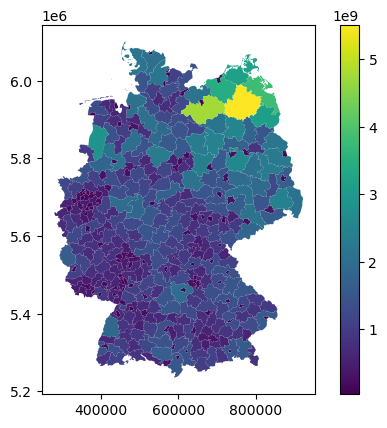

In [4]:
gdf.plot('area',legend=True)

# load data from Regionalstatistik

In [5]:
set_db('regio')

In [6]:
students = Table(name='21311-01-01-4')
population = Table(name='12411-01-01-4')

In [7]:
students.get_data()
population.get_data()

/Users/macbookpro/Git Repos/pystatis/src/pystatis/table.py:43: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(data_str, sep=";")


In [8]:
df_students = students.data
df_population = population.data

## rename columns of interest

In [11]:
students.metadata

{'Ident': {'Service': 'metadata', 'Method': 'table'},
 'Status': {'Code': 0, 'Content': 'erfolgreich', 'Type': 'Information'},
 'Parameter': {'username': '********************',
  'password': '********************',
  'name': '21311-01-01-4',
  'area': 'Alle',
  'language': 'de'},
 'Object': {'Code': '21311-01-01-4',
  'Content': 'Studierende nach Geschlecht, Nationalität und\nFächergruppen - regionale Tiefe: Kreise und krfr. Städte',
  'Time': {'From': 'WS 2015/16', 'To': 'WS 2021/22'},
  'Valid': 'false',
  'Structure': {'Head': {'Code': '21311',
    'Content': 'Statistik der Studenten',
    'Type': 'Statistik',
    'Values': None,
    'Selected': None,
    'Structure': [{'Code': 'HS-W02',
      'Content': 'Studierende (im Kreisgebiet)',
      'Type': 'Merkmal',
      'Values': None,
      'Selected': None,
      'Structure': None,
      'Updated': 'see parent'}],
    'Updated': 'see parent'},
   'Columns': [{'Code': 'SEMEST',
     'Content': 'Semester',
     'Type': 'Merkmal',
     

In [12]:
df_students.rename(
    columns={
        '1_Auspraegung_Label': 'region', 
        '1_Auspraegung_Code': 'ags',
        '2_Auspraegung_Label': 'geschlecht', 
        '3_Auspraegung_Label': 'nation', 
        '4_Auspraegung_Label': 'fach', 
        'HS-W02__Studierende_(im_Kreisgebiet)__Anzahl': 'studierende',
    },
    inplace=True
)

In [13]:
df_population.rename(
    columns={
        '1_Auspraegung_Label': 'region', 
        '1_Auspraegung_Code': 'ags',
        '2_Auspraegung_Label': 'geschlecht', 
        'BEVSTD__Bevoelkerungsstand__Anzahl': 'population'
    },
    inplace=True,
)

## get column types consistent

In [14]:
df_population.population.astype('float')

ValueError: could not convert string to float: '-'

In [15]:
df_students.studierende.replace(to_replace='-',value=0,inplace=True)
df_students.studierende.replace(to_replace='.',value=None,inplace=True)

df_population.population.replace(to_replace='-',value=0,inplace=True)
df_population.population.replace(to_replace='.',value=None,inplace=True)

In [16]:
df_students.studierende = df_students.studierende.astype(float)
df_population.population = df_population.population.astype(float)

In [17]:
df_students.ags = df_students.ags.astype(str)
df_population.ags = df_population.ags.astype(str)

In [18]:
df_students[df_students.ags == '05354']

,Statistik_Code,Statistik_Label,Zeit_Code,Zeit_Label,Zeit,1_Merkmal_Code,1_Merkmal_Label,ags,region,2_Merkmal_Code,...,geschlecht,3_Merkmal_Code,3_Merkmal_Label,3_Auspraegung_Code,nation,4_Merkmal_Code,4_Merkmal_Label,4_Auspraegung_Code,fach,studierende
8730,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG01,Geisteswissenschaften,0.0
8731,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG02,Sport,0.0
8732,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG03,"Rechts-, Wirtschafts- und Sozialwissenschaften",0.0
8733,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG04,Mathematik/Naturwissenschaften,0.0
8734,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,Insgesamt,NAT01,Nationalität (inkl. insgesamt),INSGESAMT,Insgesamt,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG05,Humanmedizin/Gesundheitswissenschaften,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,weiblich,NAT01,Nationalität (inkl. insgesamt),NATD,Deutsche,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG07,"Agrar-, Forst- und Ernährungswissensch., Veterinär",0.0
8816,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,weiblich,NAT01,Nationalität (inkl. insgesamt),NATD,Deutsche,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG08,Ingenieurwissenschaften,0.0
8817,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,weiblich,NAT01,Nationalität (inkl. insgesamt),NATD,Deutsche,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG09,"Kunst, Kunstwissenschaft",0.0
8818,21311,Statistik der Studenten,SEMEST,Semester,WS 2021/22,KREISE,Kreise und kreisfreie Städte,05354,"Aachen, Kreis",GESINS,...,weiblich,NAT01,Nationalität (inkl. insgesamt),NATD,Deutsche,HS-FG2,Fächergruppe (mit Insgesamt),HS-FG10,Außerhalb der Studienbereichsgliederung,0.0


## only interested in total numbers of students and population

In [19]:
idx_total = df_students[(df_students.nation=='Insgesamt')&(df_students.geschlecht=='Insgesamt')&(df_students.fach=='Insgesamt')].index
df_students_totals = df_students.loc[idx_total,['region','ags','studierende']]

In [20]:
idx_total = df_population[df_population.geschlecht=='Insgesamt'].index
df_population_totals = df_population.loc[idx_total,['region','ags','population']]

In [21]:
df_students_totals

,region,ags,studierende
9,Deutschland,DG,2941915.0
99,Schleswig-Holstein,01,67447.0
189,"Flensburg, kreisfreie Stadt",01001,9960.0
279,"Kiel, kreisfreie Stadt",01002,36321.0
369,"Lübeck, kreisfreie Stadt, Hansestadt",01003,13850.0
...,...,...,...
47979,"Saalfeld-Rudolstadt, Landkreis",16073,0.0
48069,Saale-Holzland-Kreis,16074,0.0
48159,Saale-Orla-Kreis,16075,0.0
48249,"Greiz, Landkreis",16076,0.0


In [22]:
df_population_totals

,region,ags,population
0,Deutschland,DG,84358845.0
3,Schleswig-Holstein,01,2953270.0
6,"Flensburg, kreisfreie Stadt",01001,92550.0
9,"Kiel, kreisfreie Stadt",01002,247717.0
12,"Lübeck, kreisfreie Stadt, Hansestadt",01003,218095.0
...,...,...,...
1599,"Saalfeld-Rudolstadt, Landkreis",16073,101494.0
1602,Saale-Holzland-Kreis,16074,83234.0
1605,Saale-Orla-Kreis,16075,79178.0
1608,"Greiz, Landkreis",16076,96381.0


## Merge population and student data

In [23]:
df_students_pops = pd.merge(df_students_totals, df_population_totals, on=['region', 'ags'],how='outer')

In [24]:
df_students_pops

,region,ags,studierende,population
0,Deutschland,DG,2941915.0,84358845.0
1,Schleswig-Holstein,01,67447.0,2953270.0
2,"Flensburg, kreisfreie Stadt",01001,9960.0,92550.0
3,"Kiel, kreisfreie Stadt",01002,36321.0,247717.0
4,"Lübeck, kreisfreie Stadt, Hansestadt",01003,13850.0,218095.0
...,...,...,...,...
533,"Saalfeld-Rudolstadt, Landkreis",16073,0.0,101494.0
534,Saale-Holzland-Kreis,16074,0.0,83234.0
535,Saale-Orla-Kreis,16075,0.0,79178.0
536,"Greiz, Landkreis",16076,0.0,96381.0


In [25]:
df_students_pops['rate']=df_students_pops.studierende/df_students_pops.population*10000
df_students_pops

,region,ags,studierende,population,rate
0,Deutschland,DG,2941915.0,84358845.0,348.738179
1,Schleswig-Holstein,01,67447.0,2953270.0,228.380744
2,"Flensburg, kreisfreie Stadt",01001,9960.0,92550.0,1076.175041
3,"Kiel, kreisfreie Stadt",01002,36321.0,247717.0,1466.229609
4,"Lübeck, kreisfreie Stadt, Hansestadt",01003,13850.0,218095.0,635.044361
...,...,...,...,...,...
533,"Saalfeld-Rudolstadt, Landkreis",16073,0.0,101494.0,0.000000
534,Saale-Holzland-Kreis,16074,0.0,83234.0,0.000000
535,Saale-Orla-Kreis,16075,0.0,79178.0,0.000000
536,"Greiz, Landkreis",16076,0.0,96381.0,0.000000


In [26]:
df_students_pops.rate

0       348.738179
1       228.380744
2      1076.175041
3      1466.229609
4       635.044361
          ...     
533       0.000000
534       0.000000
535       0.000000
536       0.000000
537       0.000000
Name: rate, Length: 538, dtype: float64

## check some special cases - Stadtstaaten, Landeshaupstadt, ..

In [27]:
for reg,ags in zip(df_students_pops.region,df_students_pops.ags):
    if len(ags)!=5:
        print(reg,ags)

Deutschland DG
  Schleswig-Holstein 01
  Hamburg 02
  Niedersachsen 03
    Braunschweig, Statistische Region 031
    Hannover, Statistische Region 032
      Hannover, Landeshauptstadt 03241001
    Lüneburg 033
    Weser-Ems, Statistische Region 034
  Bremen 04
  Nordrhein-Westfalen 05
    Düsseldorf, Regierungsbezirk 051
    Köln, Regierungsbezirk 053
      Aachen, kreisfreie Stadt 05334002
    Münster, Regierungsbezirk 055
    Detmold, Regierungsbezirk 057
    Arnsberg, Regierungsbezirk 059
  Hessen 06
    Darmstadt, Regierungsbezirk 064
    Gießen, Regierungsbezirk 065
    Kassel, Regierungsbezirk 066
  Rheinland-Pfalz 07
    Koblenz, Statistische Region 071
    Trier, Statistische Region 072
    Rheinhessen-Pfalz, Statistische Region 073
  Baden-Württemberg 08
    Stuttgart, Regierungsbezirk 081
    Karlsruhe, Regierungsbezirk 082
    Freiburg, Regierungsbezirk 083
    Tübingen, Regierungsbezirk 084
  Bayern 09
    Oberbayern, Regierungsbezirk 091
    Niederbayern, Regierungsbezirk 

In [28]:
for idx in df_population_totals.index:
    if 'Berlin' in df_population_totals.loc[idx].region:
        print(df_population_totals.loc[idx])

region           Berlin
ags                  11
population    3755251.0
Name: 1098, dtype: object
region              Berlin-Mitte
ags                     11001001
population                   NaN
Name: 1101, dtype: object
region              Berlin-Friedrichshain-Kreuzberg
ags                                        11002002
population                                      NaN
Name: 1104, dtype: object
region              Berlin-Pankow
ags                      11003003
population                    NaN
Name: 1107, dtype: object
region              Berlin-Charlottenburg-Wilmersdorf
ags                                          11004004
population                                        NaN
Name: 1110, dtype: object
region              Berlin-Spandau
ags                       11005005
population                     NaN
Name: 1113, dtype: object
region              Berlin-Steglitz-Zehlendorf
ags                                   11006006
population                                 NaN
Name: 1

In [29]:
for idx in df_students_totals.index:
    if 'Berlin' in df_students_totals.loc[idx].region:
        print(df_students_totals.loc[idx])

region           Berlin
ags                  11
studierende    203869.0
Name: 32949, dtype: object
region               Berlin-Mitte
ags                      11001001
studierende                   NaN
Name: 33039, dtype: object
region               Berlin-Friedrichshain-Kreuzberg
ags                                         11002002
studierende                                      NaN
Name: 33129, dtype: object
region               Berlin-Pankow
ags                       11003003
studierende                    NaN
Name: 33219, dtype: object
region               Berlin-Charlottenburg-Wilmersdorf
ags                                           11004004
studierende                                        NaN
Name: 33309, dtype: object
region               Berlin-Spandau
ags                        11005005
studierende                     NaN
Name: 33399, dtype: object
region               Berlin-Steglitz-Zehlendorf
ags                                    11006006
studierende                    

In [30]:
for idx in df_students_pops.index:
    if 'Berlin' in df_students_pops.loc[idx].region:
        print(df_students_pops.loc[idx])

region             Berlin
ags                    11
studierende      203869.0
population      3755251.0
rate           542.890475
Name: 366, dtype: object
region               Berlin-Mitte
ags                      11001001
studierende                   NaN
population                    NaN
rate                          NaN
Name: 367, dtype: object
region               Berlin-Friedrichshain-Kreuzberg
ags                                         11002002
studierende                                      NaN
population                                       NaN
rate                                             NaN
Name: 368, dtype: object
region               Berlin-Pankow
ags                       11003003
studierende                    NaN
population                     NaN
rate                           NaN
Name: 369, dtype: object
region               Berlin-Charlottenburg-Wilmersdorf
ags                                           11004004
studierende                                       

In [31]:
for idx in gdf.index:
    if 'Hamburg' in gdf.loc[idx].GEN:
        print(gdf.loc[idx].AGS)

02000


In [32]:
df_students_pops.loc[df_students_pops.ags=='11','ags']='11000'
df_students_pops.loc[df_students_pops.ags=='02','ags']='02000'

In [33]:
df_students_pops.loc[df_students_pops.ags=='04011']

,region,ags,studierende,population,rate
72,"Bremen, kreisfreie Stadt",04011,34577.0,569396.0,607.257515


In [34]:
for idx in df_students_pops.index:
    if 'Köln' in df_students_pops.loc[idx].region:
        print(df_students_pops.loc[idx])

region             Köln, Regierungsbezirk
ags                                   053
studierende                      229880.0
population                      4527594.0
rate                           507.731038
Name: 91, dtype: object
region               Köln, kreisfreie Stadt
ags                                   05315
studierende                        104383.0
population                        1084831.0
rate                             962.205173
Name: 93, dtype: object


In [35]:
for idx in gdf.index:
    if 'Köln' in gdf.loc[idx].GEN:
        print(gdf.loc[idx].AGS)

05315


# Merge data and shape file and plot

In [36]:
gdf_merged = gdf.merge(df_students_pops, left_on='AGS', right_on='ags', how='inner')

<Axes: >

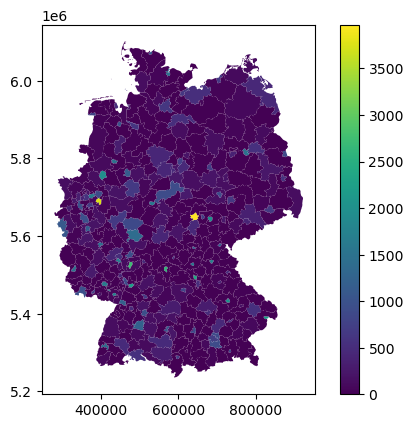

In [42]:
gdf_merged.plot('rate',legend=True)

In [40]:
gdf_merged.plot?

Signature:      gdf_merged.plot(*args, **kwargs)
Type:           GeoplotAccessor
String form:    <geopandas.plotting.GeoplotAccessor object at 0x124409850>
File:           ~/miniforge3/envs/pystatis/lib/python3.11/site-packages/geopandas/plotting.py
Docstring:     
Plot a GeoDataFrame.

Generate a plot of a GeoDataFrame with matplotlib.  If a
column is specified, the plot coloring will be based on values
in that column.

Parameters
----------
column : str, np.array, pd.Series (default None)
    The name of the dataframe column, np.array, or pd.Series to be plotted.
    If np.array or pd.Series are used then it must have same length as
    dataframe. Values are used to color the plot. Ignored if `color` is
    also set.
kind: str
    The kind of plots to produce. The default is to create a map ("geo").
    Other supported kinds of plots from pandas:

    - 'line' : line plot
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : BoxPlot

In [287]:
gdf_merged.ags

0      01001
1      01002
2      01003
3      01004
4      01051
       ...  
395    16073
396    16074
397    16075
398    16076
399    16077
Name: ags, Length: 400, dtype: object

In [286]:
gdf.AGS

0      01001
1      01002
2      01003
3      01004
4      01051
       ...  
395    16073
396    16074
397    16075
398    16076
399    16077
Name: AGS, Length: 400, dtype: object